<a href="https://colab.research.google.com/github/Jatellez86/Automatizacion_Descarga/blob/main/Prueba_analiticia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ALGORITMO PARA EL ANALISISI COMPORTAMIENTO DE VALIDACION DE PASAJEROS EMPRESA CONSORCIO EXPRESS**

Montamos nuestro drive en nuestro entorno de google colab, para hacer el montaje importamos el metodo 'mount' y hacemos la conexion, aqui es importante otorgar permisos necesarios y tener nuestra carpeta compartida en nuestra unidad!

In [2]:
# importamos el modulo correspondiente
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Creamos un algortimo que nos permita conectar a la carpeta, listar los arhivos disponibles y combinar todos los datos en un solo dataframe, de igual manera crear la logica para que nos notifique las acciones de cada linea

In [23]:
import os
import pandas as pd

# Ruta de la carpeta en Google Drive
folder_path = '/content/drive/MyDrive/Desglosado'

# Lista para almacenar los DataFrames
dfs = []

# Listar todos los archivos en la carpeta
for file_name in os.listdir(folder_path):
    # Construir la ruta completa del archivo
    file_path = os.path.join(folder_path, file_name)

    # Verificar si el archivo es un .csv
    if file_name.endswith('.csv'):
        # Leer el archivo CSV y añadirlo a la lista de DataFrames
        df = pd.read_csv(file_path)
        dfs.append(df)
        #print(f'Archivo {file_name} leído con éxito.')

# combinar todos los DataFrames en uno solo
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    #print('Todos los archivos CSV han sido combinados en un solo DataFrame.')


Identificamos los viajes que se ejecutados, con lo cual descargamos los viajes que no tuvieron kilometraje realizado (diferente de cero)

In [4]:
# descartamos viajes con km en 0
df_filtrado = combined_df[combined_df['DistanciaComputable'] != '0,000']


Seleccionamos las columnas necesarias para el analisis y agrupamos los viaje teniedo en cuenta, Fecha, Linea, coche y viaje linea como llave principal

In [24]:
# ajustamos datos categoricos de concesionario (empresa)

# Crear un diccionario con los reemplazos
reemplazos_operador = {
    '[111] D': 'san_cristobal',
    '[101] N': 'usaquen'
}

# Crear una nueva columna reemplazando los valores según el diccionario
df_filtrado['empresa'] = df_filtrado['Operador'].replace(reemplazos_operador)

# Seleccionar las columnas especificadas
final_df = df_filtrado[['Fecha', 'empresa', 'IDViaje', 'Linea', 'Coche', 'ViajeLinea', 'Ruta']]

# Convertir los nombres de las columnas a minúsculas para un manejo mas limpio
final_df.columns = final_df.columns.str.lower()

# Definir las columnas para agrupar
group_columns = ['fecha', 'empresa', 'linea', 'ruta', 'coche', 'viajelinea', 'idviaje']

# Crear una nueva columna con el conteo de cada fila en la agrupación
final_df['conteo'] = final_df.groupby(group_columns)['fecha'].transform('count')

grouped_df = final_df.groupby(group_columns).size().reset_index(name='conteo')
# print(grouped_df.head())


<ipython-input-24-ed840aed431e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['conteo'] = final_df.groupby(group_columns)['fecha'].transform('count')


Exportamos el archivo a una ruta especifica en el directorio de google drive

In [6]:
# exportamos archivo
# Ruta de la carpeta en tu Google Drive para guardar el DataFrame
folder_path = '/content/drive/MyDrive/out_desglosado'

# Nombre del archivo CSV
file_name = 'df_final.csv'

# Ruta completa del archivo
file_path = f'{folder_path}/{file_name}'

# Guardar el DataFrame como un archivo CSV en Google Drive
grouped_df.to_csv(file_path, index=False)

print(f'DataFrame guardado con éxito en {file_path}')


DataFrame guardado con éxito en /content/drive/MyDrive/out_desglosado/df_final.csv


Cargamos datos de pasajeros para los meses de Julio y Agosto, los cuales estan almacenados en un directorio especifico de google drive

In [25]:
# Montar Google Drive
drive.mount('/content/drive')

# Ruta a la carpeta 'pasajeros' en Google Drive
folder_path = '/content/drive/MyDrive/pasajeros'

# Ruta completa a cada archivo .xlsx
file_path_julio = os.path.join(folder_path, 'validaciones_julio.xlsx')
file_path_agosto = os.path.join(folder_path, 'validaciones_agosto.xlsx')

# Nombre de la hoja a leer
sheet_name = 'Resumen Operador Ruta Intervalo'

# Leer la hoja especificada de cada archivo, saltando las primeras 6 filas y asignarla a una variable
pasajeros_julio = pd.read_excel(file_path_julio, sheet_name=sheet_name, skiprows=6, engine='openpyxl')
pasajeros_agosto = pd.read_excel(file_path_agosto, sheet_name=sheet_name, skiprows=6, engine='openpyxl')

# Eliminar la primera columna de cada DataFrame
pasajeros_julio = pasajeros_julio.drop(pasajeros_julio.columns[0], axis=1)
pasajeros_agosto = pasajeros_agosto.drop(pasajeros_agosto.columns[0], axis=1)

# Verificar los DataFrames
# print(pasajeros_julio.head())
# print(pasajeros_agosto.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Pivoteamos los datos para tener datos unicos por filas y fechas para un mejor tratamiento de datos

In [8]:
# filtramos los datos para el concesionaro o empresa que se requiere el analisis
pasajeros_julio_b = pasajeros_julio[pasajeros_julio['Operador'] == '(001) CONSORCIO EXPRESS']

# Pivote fecha
df_melted = pd.melt(pasajeros_julio_b,
                    id_vars=["Operador", "Ruta Consolidada", "Intervalo"],
                    value_vars=pasajeros_julio.columns[3:-1],  # Excluyendo la columna 'Total general'
                    var_name="Fecha",
                    value_name="Validaciones")

# Convertir la columna de fecha a un formato datetime
df_melted["Fecha"] = pd.to_datetime(df_melted["Fecha"])

df_melted.head()


,Operador,Ruta Consolidada,Intervalo,Fecha,Validaciones
0,(001) CONSORCIO EXPRESS,(1064) T13,13:00:00,2023-07-01,178.0
1,(001) CONSORCIO EXPRESS,(1064) T13,13:15:00,2023-07-01,166.0
2,(001) CONSORCIO EXPRESS,(1064) T13,13:30:00,2023-07-01,162.0
3,(001) CONSORCIO EXPRESS,(1064) T13,13:45:00,2023-07-01,154.0
4,(001) CONSORCIO EXPRESS,(1064) T13,10:00:00,2023-07-01,162.0


Trasnformamos los datos para poder agrupar por franja horaria, y se identifican datos atipicos para la ruta C142 los cuales aparecen solo para dos dias del periodo de tiempo, los mismos se excluyen para no tener sesgos en la prediccion

In [9]:
# Convertir la columna "Intervalo" a tipo string
df_melted['Intervalo'] = df_melted['Intervalo'].astype(str)

# Extraer la hora y almacenarla en una nueva columna llamada "Hora"
df_melted['Hora'] = df_melted['Intervalo'].str.split(":").str[0].astype(int)

# Agrupar por las columnas especificadas y sumar la columna "Validaciones"
df_grouped = df_melted.groupby(['Fecha', 'Operador', 'Ruta Consolidada', 'Hora'])['Validaciones'].sum().reset_index()

# Reemplazar paréntesis en la columna "Ruta Consolidada" para hacer match con datos de viajes desglosados
df_grouped['Ruta Consolidada'] = df_grouped['Ruta Consolidada'].str.replace("(", "[").str.replace(")", "]")

# Eliminar la cadena "_CEGM" en la columna "Ruta Consolidada" para hacer match con datos de viaje desglosado
df_grouped['Ruta Consolidada'] = df_grouped['Ruta Consolidada'].str.replace("_CEGM", "")

# Los datos de la ruta '[1315] C142' son atipicos asi que se excluyen
df_grouped = df_grouped[df_grouped['Ruta Consolidada'] != '[1315] C142']


df_grouped.head()


<ipython-input-9-e6ac6b87afc3>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_grouped['Ruta Consolidada'] = df_grouped['Ruta Consolidada'].str.replace("(", "[").str.replace(")", "]")


,Fecha,Operador,Ruta Consolidada,Hora,Validaciones
0,2023-07-01,(001) CONSORCIO EXPRESS,[1064] T13,0,16.0
1,2023-07-01,(001) CONSORCIO EXPRESS,[1064] T13,3,3.0
2,2023-07-01,(001) CONSORCIO EXPRESS,[1064] T13,4,288.0
3,2023-07-01,(001) CONSORCIO EXPRESS,[1064] T13,5,631.0
4,2023-07-01,(001) CONSORCIO EXPRESS,[1064] T13,6,747.0


Se exportan los datos a un directorio especifico de google drive

In [10]:
# exportamos archivo
# Ruta de la carpeta en Google Drive para  guardar el DataFrame
folder_path = '/content/drive/MyDrive/out_desglosado'

# Nombre del archivo CSV
file_name = 'df_pax_julio.csv'

# Ruta completa del archivo
file_path = f'{folder_path}/{file_name}'

# Guardar el DataFrame como un archivo CSV en Google Drive
df_grouped.to_csv(file_path, index=False)

# print(f'DataFrame julio guardado con éxito en {file_path}')

DataFrame julio guardado con éxito en /content/drive/MyDrive/out_desglosado/df_pax_julio.csv


Se realiza el mismo calculo para el mes de Agosto

In [11]:
# print(pasajeros_agosto.head())

# filtramos los datos para el concesionaro o empresa que se requiere el analisis
pasajeros_agosto_b = pasajeros_agosto[pasajeros_agosto['Operador'] == '(001) CONSORCIO EXPRESS']

# Pivote fecha
df_melted = pd.melt(pasajeros_agosto_b,
                    id_vars=["Operador", "Ruta Consolidada", "Intervalo"],
                    value_vars=pasajeros_agosto.columns[3:-1],  # Excluyendo la columna 'Total general'
                    var_name="Fecha",
                    value_name="Validaciones")

# Convertir la columna de fecha a un formato datetime
df_melted["Fecha"] = pd.to_datetime(df_melted["Fecha"])

df_melted.head()

# Convertir la columna "Intervalo" a tipo string
df_melted['Intervalo'] = df_melted['Intervalo'].astype(str)

# Extraer la hora y almacenarla en una nueva columna llamada "Hora"
df_melted['Hora'] = df_melted['Intervalo'].str.split(":").str[0].astype(int)

# Agrupar por las columnas especificadas y sumar la columna "Validaciones"
df_grouped = df_melted.groupby(['Fecha', 'Operador', 'Ruta Consolidada', 'Hora'])['Validaciones'].sum().reset_index()

# Reemplazar paréntesis en la columna "Ruta Consolidada" para hacer match con datos de viajes desglosados
df_grouped['Ruta Consolidada'] = df_grouped['Ruta Consolidada'].str.replace("(", "[").str.replace(")", "]")

# Eliminar la cadena "_CEGM" en la columna "Ruta Consolidada" para hacer match con datos de viaje desglosado
df_grouped['Ruta Consolidada'] = df_grouped['Ruta Consolidada'].str.replace("_CEGM", "")

# Los datos de la ruta '[1315] C142' son atipicos asi que se excluyen
df_grouped_agosto = df_grouped[df_grouped['Ruta Consolidada'] != '[1315] C142']


df_grouped.head()


# exportamos archivo
# Ruta de la carpeta en Google Drive para  guardar el DataFrame
folder_path = '/content/drive/MyDrive/out_desglosado'

# Nombre del archivo CSV
file_name = 'df_pax_Agosto.csv'

# Ruta completa del archivo
file_path = f'{folder_path}/{file_name}'

# Guardar el DataFrame como un archivo CSV en Google Drive
df_grouped_agosto.to_csv(file_path, index=False)

# print(f'DataFrame agosto guardado con éxito en {file_path}')

                  Operador Ruta Consolidada Intervalo  2023-08-01 00:00:00  \
0  (001) CONSORCIO EXPRESS       (1064) T13  13:00:00                274.0   
1  (001) CONSORCIO EXPRESS       (1064) T13  13:15:00                253.0   
2  (001) CONSORCIO EXPRESS       (1064) T13  13:30:00                248.0   
3  (001) CONSORCIO EXPRESS       (1064) T13  13:45:00                271.0   
4  (001) CONSORCIO EXPRESS       (1064) T13  10:00:00                221.0   

   2023-08-02 00:00:00  2023-08-03 00:00:00  2023-08-04 00:00:00  \
0                285.0                290.0                282.0   
1                258.0                281.0                307.0   
2                277.0                229.0                280.0   
3                225.0                201.0                287.0   
4                242.0                198.0                301.0   

   2023-08-05 00:00:00  2023-08-06 00:00:00  2023-08-07 00:00:00  ...  \
0                204.0                 70.0      

<ipython-input-11-bf94a525bc17>:28: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_grouped['Ruta Consolidada'] = df_grouped['Ruta Consolidada'].str.replace("(", "[").str.replace(")", "]")


DataFrame agosto guardado con éxito en /content/drive/MyDrive/out_desglosado/df_pax_Agosto.csv


# Se calculan medidas de tendencia central y se hace un analisis exploratorio de los **datos**

       Fecha                 Operador Ruta Consolidada  Hora  Validaciones
0 2023-08-01  (001) CONSORCIO EXPRESS       [1064] T13     0           5.0
1 2023-08-01  (001) CONSORCIO EXPRESS       [1064] T13     2           0.0
2 2023-08-01  (001) CONSORCIO EXPRESS       [1064] T13     3          35.0
3 2023-08-01  (001) CONSORCIO EXPRESS       [1064] T13     4         480.0
4 2023-08-01  (001) CONSORCIO EXPRESS       [1064] T13     5        1368.0
Media: 180.59375584539256
Mediana: 103.0
Moda: 0.0
Columnas categóricas: Index(['Operador', 'Ruta Consolidada'], dtype='object')
Columnas numéricas: Index(['Fecha', 'Hora', 'Validaciones'], dtype='object')


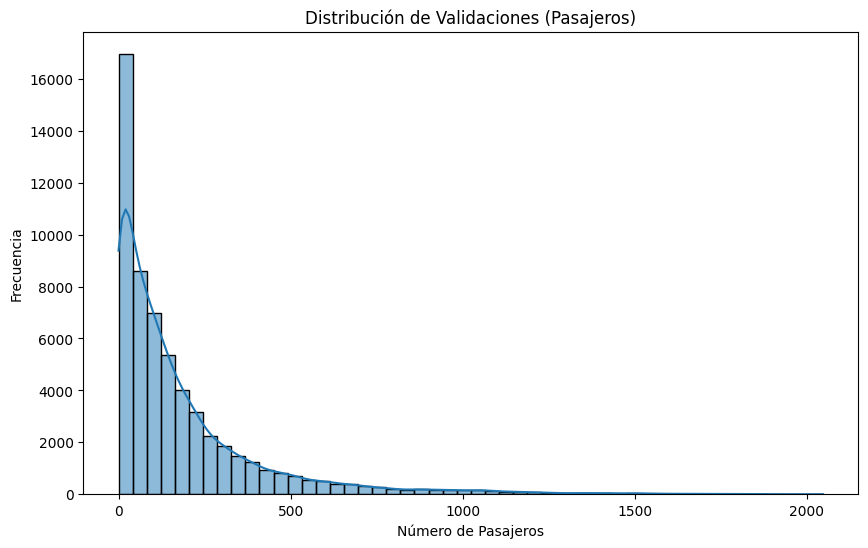

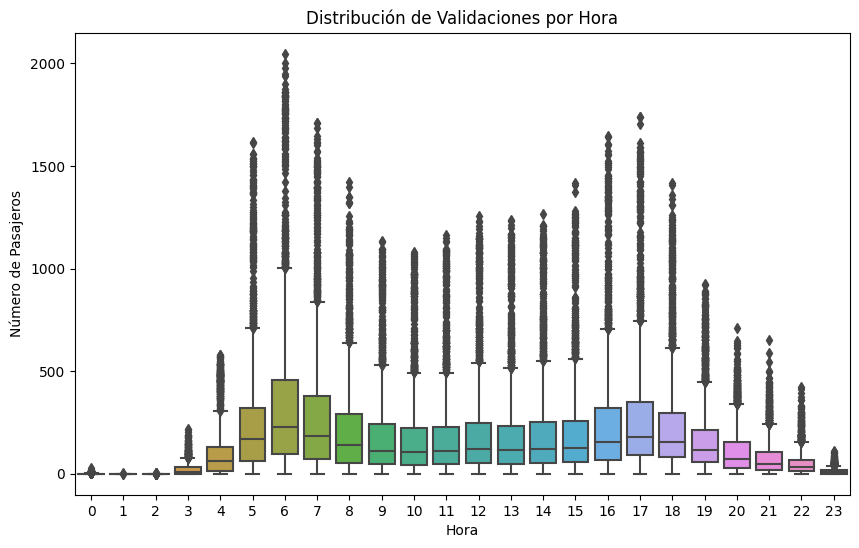

In [12]:
# 1. Importación de las bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Carga del archivo CSV (Asegúrate de subir el archivo a tu entorno de Colab primero)
df_pax_julio = df_grouped

# 3. Exploración de los datos
print(df_pax_julio.head())

# 4. Medidas de tendencia central para la columna "Validaciones"
mean_validaciones = df_pax_julio['Validaciones'].mean()
median_validaciones = df_pax_julio['Validaciones'].median()
mode_validaciones = df_pax_julio['Validaciones'].mode().iloc[0]
print(f"Media: {mean_validaciones}\nMediana: {median_validaciones}\nModa: {mode_validaciones}")

# 5. Categorización de tipos de datos
categorical_columns = df_pax_julio.select_dtypes(include=['object']).columns
numerical_columns = df_pax_julio.select_dtypes(exclude=['object']).columns
print(f"Columnas categóricas: {categorical_columns}\nColumnas numéricas: {numerical_columns}")

# 6. Visualización de datos con gráficos
# Distribución de Validaciones
plt.figure(figsize=(10, 6))
sns.histplot(df_pax_julio['Validaciones'], bins=50, kde=True)
plt.title('Distribución de Validaciones (Pasajeros)')
plt.xlabel('Número de Pasajeros')
plt.ylabel('Frecuencia')
plt.show()

# Validaciones por Hora
plt.figure(figsize=(10, 6))
sns.boxplot(x='Hora', y='Validaciones', data=df_pax_julio)
plt.title('Distribución de Validaciones por Hora')
plt.xlabel('Hora')
plt.ylabel('Número de Pasajeros')
plt.show()


In [18]:
import pandas as pd
from datetime import timedelta

# Cargando el dataset de Julio
df_pax_julio = df_pax_julio

# Agrupando datos por día y ruta para obtener el total diario de validaciones para cada ruta
df_agrupado_julio = df_pax_julio.groupby(['Fecha', 'Ruta Consolidada']).sum()['Validaciones'].reset_index()

# Función para realizar predicciones usando media móvil
def predict_moving_average(data, window_size, steps):
    """Función para realizar predicciones usando media móvil."""
    last_values = data[-window_size:]
    return [last_values.mean()] * steps

# Parámetros para la media móvil
window_size = 7  # Usar la última semana de julio para la media móvil

all_predictions_ma = []

for route in df_agrupado_julio['Ruta Consolidada'].unique():
    df_route = df_agrupado_julio[df_agrupado_julio['Ruta Consolidada'] == route]
    predictions_route = predict_moving_average(df_route['Validaciones'].values, window_size, 184)

    fechas_prediccion_route = [pd.to_datetime(df_route['Fecha'].iloc[-1]) + timedelta(days=i) for i in range(1, 185)]

    for date, pred in zip(fechas_prediccion_route, predictions_route):
        all_predictions_ma.append({
            'Fecha': date,
            'Ruta Consolidada': route,
            'Predicciones': pred
        })

# Creando dataframe con las predicciones usando media móvil
df_predicciones_ma = pd.DataFrame(all_predictions_ma)

# Cargando el dataframe de proyección de población
df_proyeccion = pd.read_csv('proyeccion_localidad.csv', encoding='ISO-8859-1')

# Filtrando los datos de proyección para 2023 y 2024
df_proyeccion_2023 = df_proyeccion[df_proyeccion['AÑO'] == 2023]
df_proyeccion_2024 = df_proyeccion[df_proyeccion['AÑO'] == 2024]

# Convirtiendo las columnas 'TOTAL' a numérico
df_proyeccion_2023['TOTAL'] = df_proyeccion_2023['TOTAL'].str.replace(',', '').astype(float)
df_proyeccion_2024['TOTAL'] = df_proyeccion_2024['TOTAL'].str.replace(',', '').astype(float)

# Calculando la tasa de crecimiento
poblacion_2023 = df_proyeccion_2023['TOTAL'].sum()
poblacion_2024 = df_proyeccion_2024['TOTAL'].sum()
tasa_crecimiento = poblacion_2024 / poblacion_2023

# Ajustando las predicciones usando la tasa de crecimiento
df_predicciones_ma['Predicciones Ajustadas'] = df_predicciones_ma['Predicciones'] * tasa_crecimiento

# exportamos archivo
# Ruta de la carpeta en Google Drive para  guardar el DataFrame
folder_path = '/content/drive/MyDrive/out_desglosado'

# Nombre del archivo CSV
file_name = 'prediccion.csv'

# Ruta completa del archivo
file_path = f'{folder_path}/{file_name}'

# Guardar el DataFrame como un archivo CSV en Google Drive
df_predicciones_ma.to_csv(file_path, index=False)

print(f'DataFrame prediccion guardado con éxito en {file_path}')


<ipython-input-18-5f39eb841401>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_agrupado_julio = df_pax_julio.groupby(['Fecha', 'Ruta Consolidada']).sum()['Validaciones'].reset_index()


DataFrame prediccion guardado con éxito en /content/drive/MyDrive/out_desglosado/prediccion.csv


<ipython-input-18-5f39eb841401>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proyeccion_2023['TOTAL'] = df_proyeccion_2023['TOTAL'].str.replace(',', '').astype(float)
<ipython-input-18-5f39eb841401>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proyeccion_2024['TOTAL'] = df_proyeccion_2024['TOTAL'].str.replace(',', '').astype(float)
